Bone Masking

In [1]:
import cv2
from mayavi import mlab
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import skeletonize, opening, binary_opening, disk
from scipy.ndimage import zoom, binary_fill_holes, distance_transform_edt
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.measure import find_contours


In [ ]:
ct_volume = nib.load("../results/3702_left_knee.nii.gz")
ct_data = ct_volume.get_fdata()
spacing = ct_volume.header.get_zooms()

In [39]:
def show_mask(mask):
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

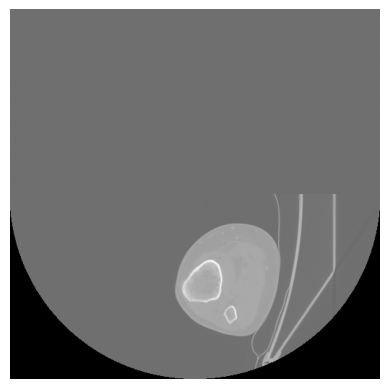

In [315]:
show_mask(ct_data[:, :, 80])

In [291]:
binary_mask = np.zeros_like(ct_data)

In [385]:
def mask_slice(i):
    slice = ct_data[:, :, i]
    zoom_in = zoom(slice, (4,4), order=0)
    blur = gaussian(zoom_in, sigma=2)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY) # 180 for slices 0-80, 240 for 80-90, 140-200 for 90--100
    zoom_out = zoom(thresh, (0.25, 0.25), order=0)
    return zoom_out

In [387]:
for i in range(130, 216):
    mask = mask_slice(i)
    filled_mask = binary_fill_holes(mask)   
    # opening = binary_opening(filled_mask, disk(1), mode="ignore")   # Morphological opening for removing lines and noises outside the region of interest while preserving small blobs
    clean_mask = remove_small_objects(filled_mask, min_size=800)    # Try different min_size such as 50, 100, 800, 1200 according to the slices

    # Use Distance Transform for slices 91 - 93
    # distance = distance_transform_edt(clean_mask, sampling=spacing[:2])
    # coords = peak_local_max(distance, footprint=np.ones((10,10)), labels=clean_mask)
    # mask = np.zeros(distance.shape, dtype=bool)
    # mask[tuple(coords.T)] = True
    # markers, _ = ndi.label(mask)
    # labels = watershed(-distance, markers, mask=clean_mask)
    # labels[labels == 2] = 0

    binary_mask[:, :, i] = clean_mask



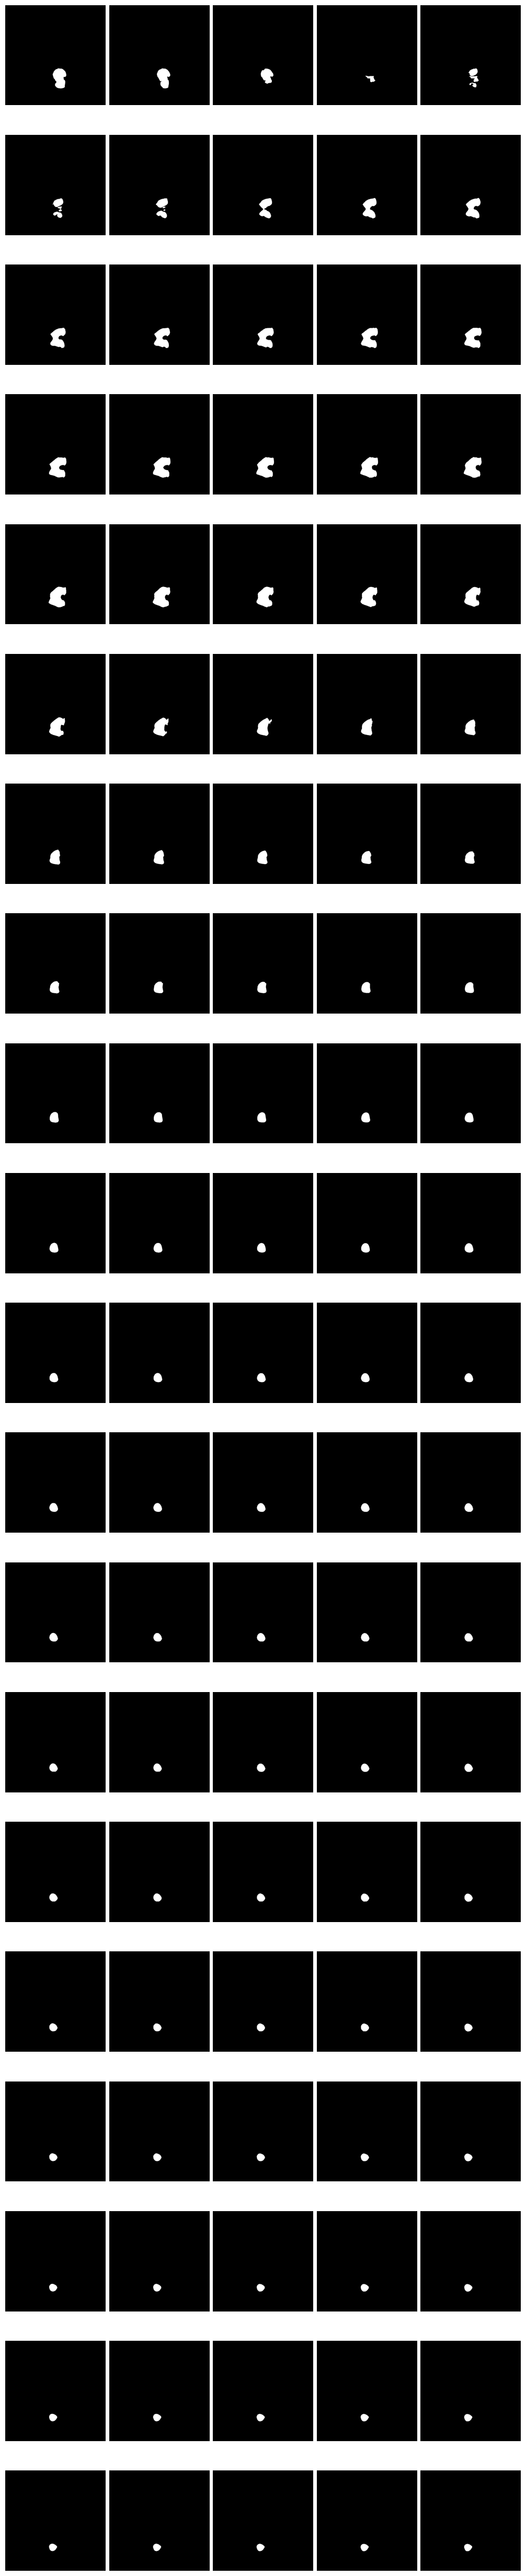

In [428]:
fig, axes = plt.subplots(20, 5, figsize=(10, 50))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[:, :, 100 + i], cmap="gray")
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

Text(0.5, 1.0, 'Sucessive zoom in and zoom out')

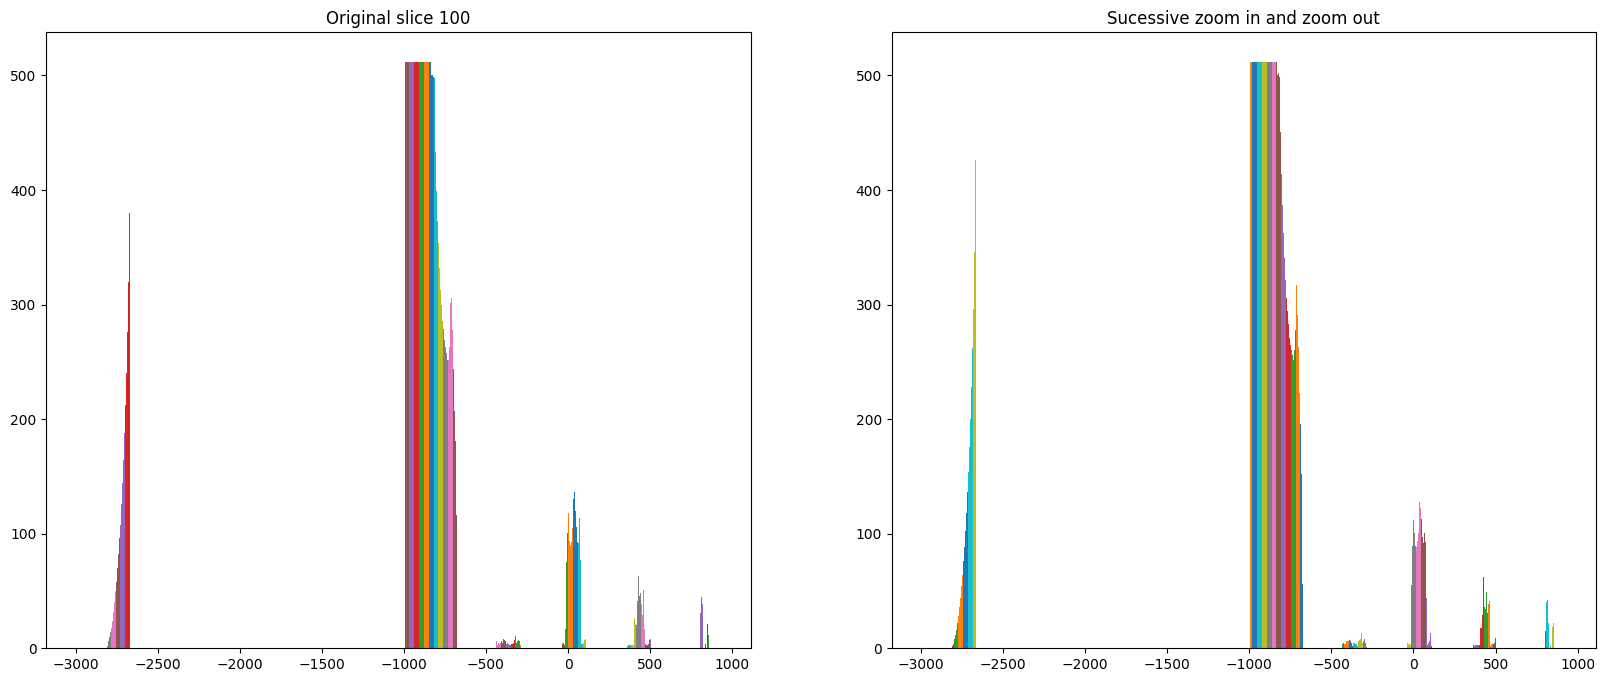

In [275]:
zoom_in = zoom(ct_data[100], (4,4), order=0)
zoom_out = zoom(zoom_in, (0.25, 0.25), order=0)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax = axes.ravel()
ax[0].hist(ct_data[100])
ax[0].set_title("Original slice 100")
ax[1].hist(zoom_out)
ax[1].set_title("Sucessive zoom in and zoom out")

In [ ]:
print(np.array_equal(ct_data[100], zoom_out)) # If True, the original slice and zoom_out is equal otherwise not.

True


In [389]:
nib.save(nib.Nifti1Image(binary_mask, affine=ct_volume.affine), filename="../results/3702_left_knee_mask_final.nii.gz")

Femur and Tibia Segmentation

In [2]:
mask_volume = nib.load("../results/3702_left_knee_mask_final.nii.gz")
mask_data = mask_volume.get_fdata()
volume_3d = np.stack(mask_data, axis=0)
spacing = mask_volume.header.get_zooms()

In [3]:
mlab.contour3d(volume_3d, color=(1, 1, 1))
mlab.title("Original Mask")
mlab.show()

In [5]:
def watershed_segmentation(volume_3d):
    distance = distance_transform_edt(volume_3d.astype(bool))
    coords = peak_local_max(distance, footprint=np.ones((100,100,100)), labels=volume_3d.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=volume_3d.astype(bool))
    return labels

In [6]:
labels = watershed_segmentation(volume_3d)

In [154]:
np.unique(labels[:, :, :104]), np.unique(labels[:, :, 108:])

(array([0, 1], dtype=int32), array([0, 2], dtype=int32))

In [8]:
nib.save(nib.Nifti1Image(labels, affine=mask_volume.affine), filename="../results/3702_left_knee_mask_segmented.nii.gz")

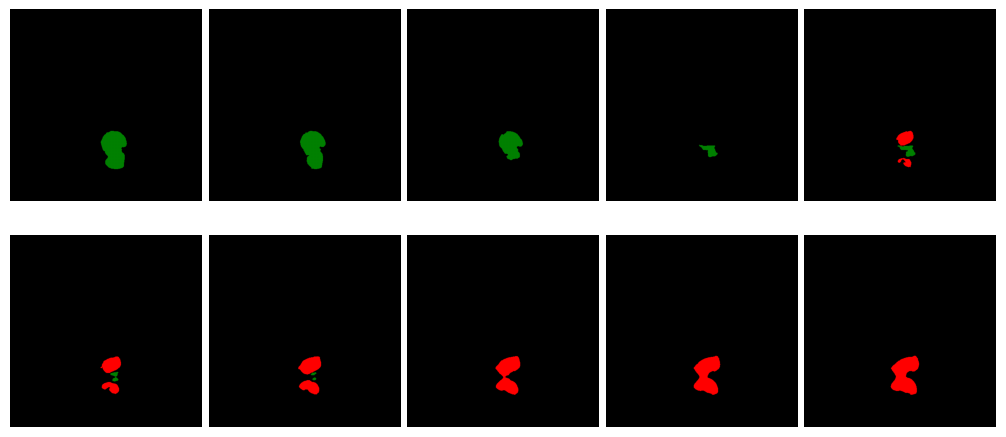

In [11]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'green', 'red'])
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(labels[:, :, i+100], cmap=cmap, vmin=0, vmax=2)
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

In [16]:
def visualize_segments(labels):

    tibia = (labels == 2).astype(np.float32)
    femur = (labels == 1).astype(np.float32)

    mlab.contour3d(tibia, color=(0, 1, 0))
    mlab.contour3d(femur, color=(1, 0, 0))
    mlab.title("Segmentation", size=1)
    mlab.show()

In [17]:
visualize_segments(labels)

Contour Adjustment

In [54]:
def expand_mask(mask_data, spacing, expansion=4.0):
    # Prepare output
    expanded_mask = np.zeros_like(mask_data)
    
    # Expand each 2D slice independently
    for i in range(0, mask_data.shape[2]):
        # Invert the mask: foreground = False, background = True
        inverted = ~mask_data[:, :, i].astype(bool)
    
        # Distance transform
        dist_map = distance_transform_edt(inverted, sampling=spacing[0:2])

        # Threshold at desired expansion distance
        expanded_mask[:, :, i] = (dist_map <= expansion) | mask_data[:, :, i].astype(bool)
    
    return expanded_mask, dist_map

In [95]:
input_masks = mask_data[:,:, 120:130]
expanded_mask, dist_map = expand_mask(input_masks, spacing=spacing)

In [ ]:
def calculate_contours(mask):
    return find_contours(mask, 0.8)

In [ ]:
def show_distmap(distance):
    plt.imshow(distance, cmap="hot")
    plt.show()

In [ ]:
def show_contours(contours, mask):
    plt.imshow(mask, cmap="gray")
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0])

Text(0.5, 1.0, 'Distance Transform')

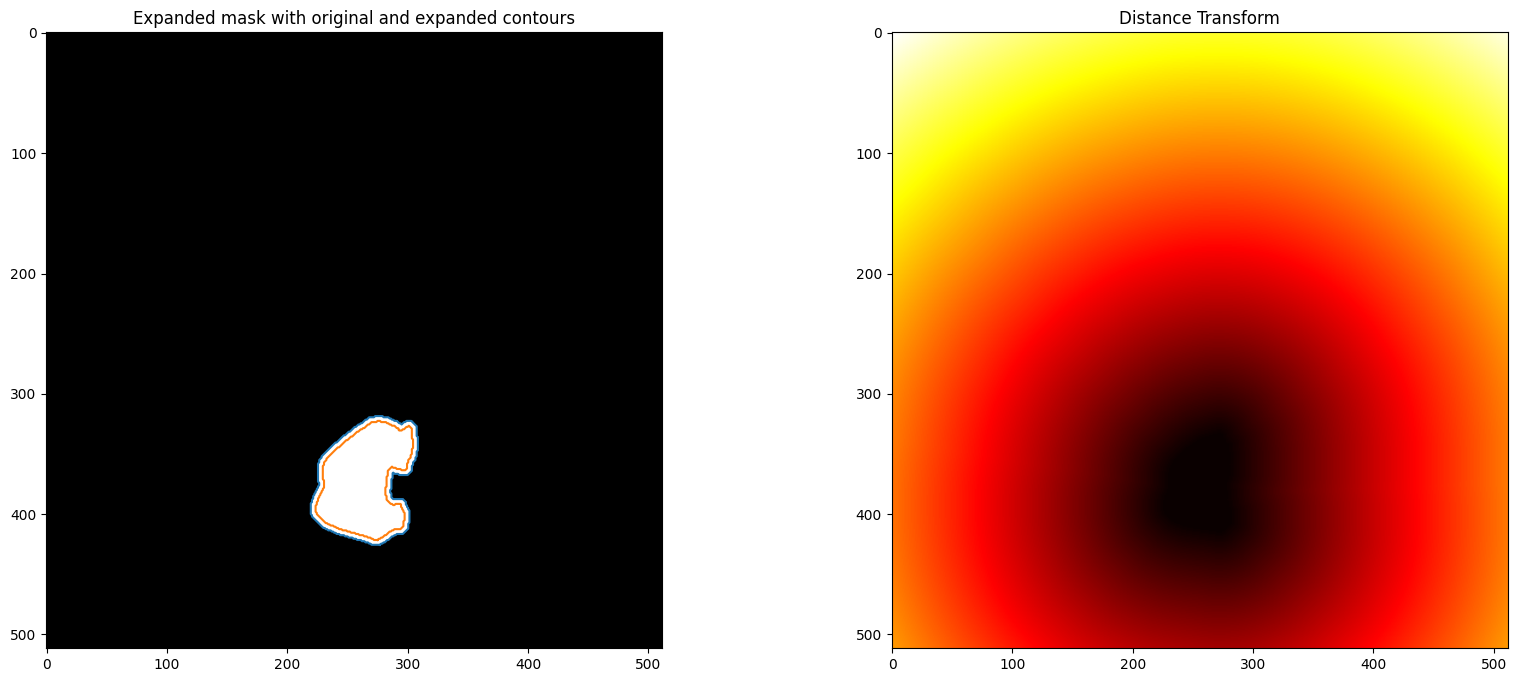

In [110]:
contours = calculate_contours(expanded_mask[:, :, 5]) + calculate_contours(input_masks[:, :, 5])
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax = axes.ravel()
ax[0].imshow(expanded_mask[:, :, 5], cmap="gray")
ax[0].plot(contours[0][:, 1], contours[0][:, 0])
ax[0].plot(contours[1][:, 1], contours[1][:, 0])
ax[0].set_title("Expanded mask with original and expanded contours")
ax[1].imshow(dist_map, cmap="hot")
ax[1].set_title("Distance Transform")

In [138]:
def random_mask(mask_data, spacing, expansion=4.0, randomness_level=0.6, seed=None):

    if seed is not None:
        np.random.seed(seed)

    random_mask = np.zeros_like(mask_data)

    for i in range(0, mask_data.shape[2]):
        binary_mask = mask_data[:, :, i].astype("bool")
        outside = distance_transform_edt(~binary_mask, sampling=spacing[0:2])
        inside = distance_transform_edt(binary_mask, sampling=spacing[0:2])
        sdf = outside.copy()
        sdf[binary_mask] = -inside[binary_mask]

        # Create a boolean mask for the expanded region
        expanded_mask = sdf <= expansion

        # Difference between expanded mask and binary mask
        shell = expanded_mask & ~binary_mask

        # Find the indices of the shell
        shell_indices = np.argwhere(shell)

        # Number of indices to select
        n_select = int(randomness_level * len(shell_indices))

        selected_indices = np.random.choice(len(shell_indices), n_select, replace=False)

        original_mask = binary_mask.copy()
        for idx in selected_indices:
            original_mask[tuple(shell_indices[idx])] = True
        random_mask[:, :, i] = original_mask
        
    return random_mask, inside, outside


In [139]:
randomized_mask, inside_map, outside_map = random_mask(input_masks, spacing=spacing)

Text(0.5, 1.0, 'Distance Transform (Outside)')

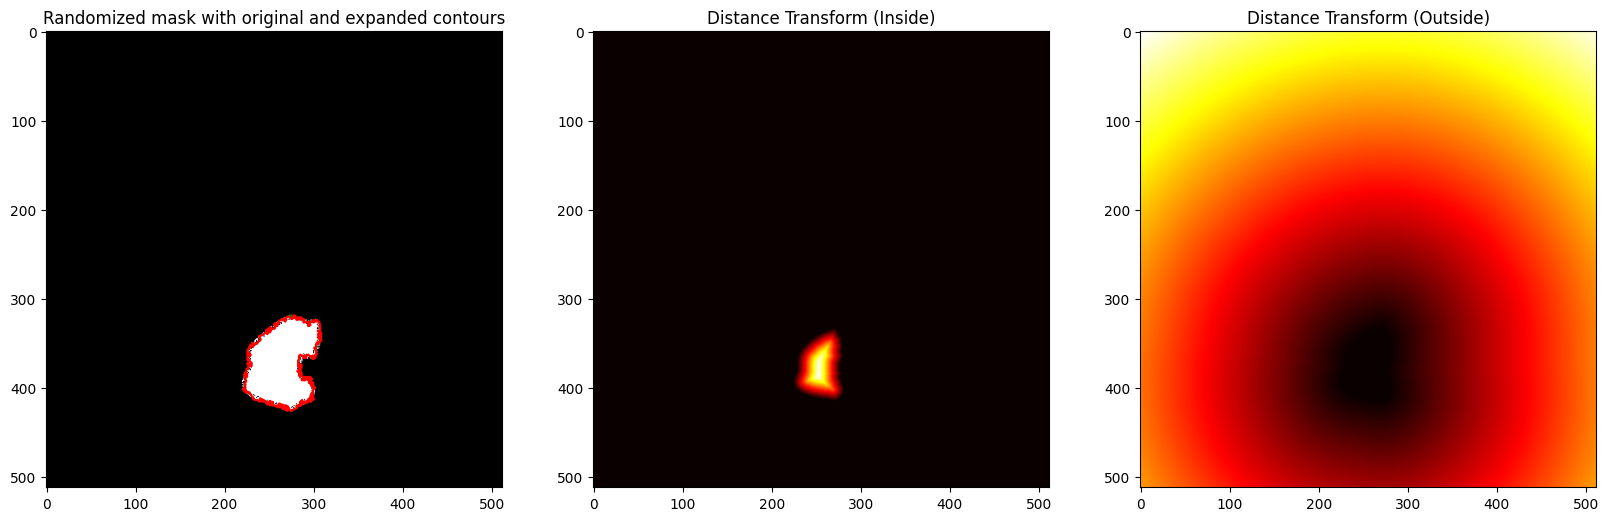

In [140]:
contours = calculate_contours(randomized_mask[:, :, 5]) + calculate_contours(input_masks[:, :, 5])
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
ax = axes.ravel()
ax[0].imshow(randomized_mask[:, :, 5], cmap="gray")
ax[0].plot(contours[0][:, 1], contours[0][:, 0], color="green")
ax[0].plot(contours[1][:, 1], contours[1][:, 0], color="red")
ax[0].set_title("Randomized mask with original and expanded contours")
ax[1].imshow(inside_map, cmap="hot")
ax[1].set_title("Distance Transform (Inside)")
ax[2].imshow(outside_map, cmap="hot")
ax[2].set_title("Distance Transform (Outside)")

In [ ]:
nib.save(nib.Nifti1Image(expanded_mask, affine=mask_volume.affine), "../results/left_knee_expanded_mask_1.nii.gz")

In [ ]:
nib.save(nib.Nifti1Image(randomized_mask, affine=mask_volume.affine), "../results/left_knee_randomized_mask_1.nii.gz")

In [29]:
expanded_mask = nib.load("../results/3702_left_knee_expanded_mask_2.nii.gz")
expanded_mask_data = expanded_mask.get_fdata()
expanded_mask_data = np.stack(expanded_mask_data, axis=0)

In [30]:
mlab.contour3d(expanded_mask_data, color=(1, 1, 1))
mlab.title("4 mm Expanded Mask")
mlab.show()

In [35]:
randomized_mask = nib.load("../results/3702_left_knee_randomized_mask_1.nii.gz")
randomized_mask_data = randomized_mask.get_fdata()
randomized_mask_data = np.stack(randomized_mask_data, axis=0)

In [36]:
mlab.contour3d(randomized_mask_data, color=(1, 1, 1))
mlab.title("Randomized Mask 1")
mlab.show()

Landmark Detection

In [2]:
segmented_volume = nib.load("../results/3702_left_knee_mask_segmented.nii.gz")
labels = segmented_volume.get_fdata()
spacing = segmented_volume.header.get_zooms()

In [3]:
tibia_3d = (labels == 1).astype(np.float32)

In [5]:
mlab.contour3d(tibia_3d, color=(1, 1, 1))
mlab.title("Tibia")
mlab.show()

In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt

def find_landmarks(tibia_3d, spacing, top_percent=15, min_x=10):

    # Identify plateau region
    z_nonzero = np.any(tibia_3d, axis=(0, 1))
    z_indices = np.where(z_nonzero)[0]
    z_cutoff = int(np.percentile(z_indices, 100 - top_percent))
    plateau_3d = np.zeros_like(tibia_3d, dtype=bool)
    plateau_3d[:, :, z_cutoff:] = tibia_3d[:, :, z_cutoff:]

    # Distance transform
    dist = distance_transform_edt(plateau_3d, sampling=spacing)

    # Skeletonization (2D slice-wise)
    skeleton_points = []
    for z in range(z_cutoff, plateau_3d.shape[2]):
        slice_mask = plateau_3d[:, :, z]
        if np.any(slice_mask):
            skel_2d = skeletonize(slice_mask)
            coords = np.argwhere(skel_2d)  # [x, y]
            for x, y in coords:
                skeleton_points.append([x, y, z])
    skeleton_points = np.array(skeleton_points)

    # Step 4: Combine with distance + x-spread + z-weight
    coords_3d = skeleton_points
    values = dist[coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2]]

    # Filter near X-midline (now used for medial-lateral)
    x_mid = np.median(coords_3d[:, 0])
    x_dists = np.abs(coords_3d[:, 0] - x_mid)
    keep_idx = np.where(x_dists > min_x)[0]
    coords_3d = coords_3d[keep_idx]
    values = values[keep_idx]
    x_dists = x_dists[keep_idx]

    # Weight score by X distance and Z height (closer to plateau top = better)
    x_weight = 1.0 + (x_dists / np.max(x_dists))
    z_scores = 1.0 - (coords_3d[:, 2] - z_cutoff) / (plateau_3d.shape[2] - z_cutoff)
    values = values * x_weight * z_scores

    # Step 5: Split medial/lateral using X-axis
    medial_idx = np.where(coords_3d[:, 0] < x_mid)[0]
    lateral_idx = np.where(coords_3d[:, 0] >= x_mid)[0]

    medial = coords_3d[medial_idx[np.argmax(values[medial_idx])]]
    lateral = coords_3d[lateral_idx[np.argmax(values[lateral_idx])]]

    return medial, lateral


In [42]:
medial, lateral =  find_landmarks(tibia_3d, spacing=spacing)

In [43]:
from mayavi import mlab
import numpy as np

def show_landmarks(volume, medial, lateral):

    mlab.contour3d(tibia_3d, color=(1, 1, 1), opacity=0.3)
    mlab.points3d(medial[0], medial[1], medial[2], color=(1, 0, 0), scale_factor=4, resolution=20)
    mlab.points3d(lateral[0], lateral[1], lateral[2], color=(0, 0, 1), scale_factor=4, resolution=20)
    mlab.show()

In [44]:
show_landmarks(tibia_3d, medial, lateral)